# Exercise 1: Implementing a Learning Rate Finder
<!-- @q -->

In this exercise, we'll implement a basic learning rate finder that helps identify good learning rates for training neural networks. The learning rate finder works by training the model for a few iterations while exponentially increasing the learning rate and monitoring the loss.

## Setup and Imports

In [50]:
# @SHOW
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings('ignore')

# Load and preprocess Fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train = X_train_full.astype('float32') / 255.0
y_train = y_train_full

# Create a simple model
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

## Part 1: Learning Rate Finder Callback


First, we'll create a callback that increases the learning rate exponentially and records the loss at each step.  You just need to fill in the definition for the `self.lr_factor` variable, and then use it to update the learning rate

In [51]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [52]:
class LearningRateFinder(tf.keras.callbacks.Callback):
    def __init__(self, min_lr=1e-7, max_lr=10, steps=200):
        super().__init__()
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.steps = steps
        self.learning_rates = []
        self.losses = []
        
        # Calculate the multiplication factor for each step
        # STUDENT TASK: Calculate the factor that, when multiplied steps times,
        # goes from min_lr to max_lr
# TODO: Replace with your code (fill)
        self.lr_factor = (max_lr / min_lr) ** (1.0 / steps)

    def on_train_begin(self, logs={}):
        # Start with minimum learning rate
        #print(f"Setting min rate {self.min_lr}")
        self.model.optimizer.learning_rate.assign(self.min_lr)
        
    def on_train_batch_end(self, batch, logs={}):
        # Get the current learning rate and loss
        lr = self.model.optimizer.learning_rate
        loss = logs['loss']
        
        # Store the values
        self.learning_rates.append(tf.keras.backend.get_value(lr))
        self.losses.append(loss)
        
        # Stop if the loss is not finite (exploding)
        if not np.isfinite(loss):
            print('Stopping - Loss is not finite!')
            self.model.stop_training = True
            return
        
        # Increase the learning rate for the next iteration
        # STUDENT TASK: Update the learning rate using the lr_factor
# TODO: Replace with your code (fill)
        new_lr = self.model.optimizer.learning_rate * self.lr_factor
        self.model.optimizer.learning_rate.assign(new_lr)

## Part 2: Finding the Learning Rate


Now we'll create a function that uses our callback to find a good learning rate.  You'll need to fill the code for model compilation and fitting.

In [53]:
def find_learning_rate(model, X, y, batch_size=64, steps=200):
    # Initialize the learning rate finder
    lr_finder = LearningRateFinder(steps=steps)
    
    # Compile the model
    # STUDENT TASK: Compile the model with SGD optimizer and sparse_categorical_crossentropy
# TODO: Replace with your code (fill)
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Calculate the number of samples to use
    num_samples = steps * batch_size
    
    # If we have more samples than we need, take a random subset
    if len(X) > num_samples:
        idx = np.random.randint(len(X), size=num_samples)
        X = X[idx]
        y = y[idx]
    
    # Train the model with the learning rate finder; make sure to include the `lr_finder` as a callback
    # and use the batch size parameter that was passed into the function

# TODO: Replace with your code (fill)
    model.fit(
        X, y,
        epochs=1,
        batch_size=batch_size,
        callbacks=[lr_finder],
        verbose=0
    )
    return lr_finder.learning_rates, lr_finder.losses

## Part 3: Visualizing and Analyzing Results


Finally, we'll create a function to plot and analyze the results.

2025-11-19 13:57:28.312197: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 40140800 exceeds 10% of free system memory.


lr 200 loss 200


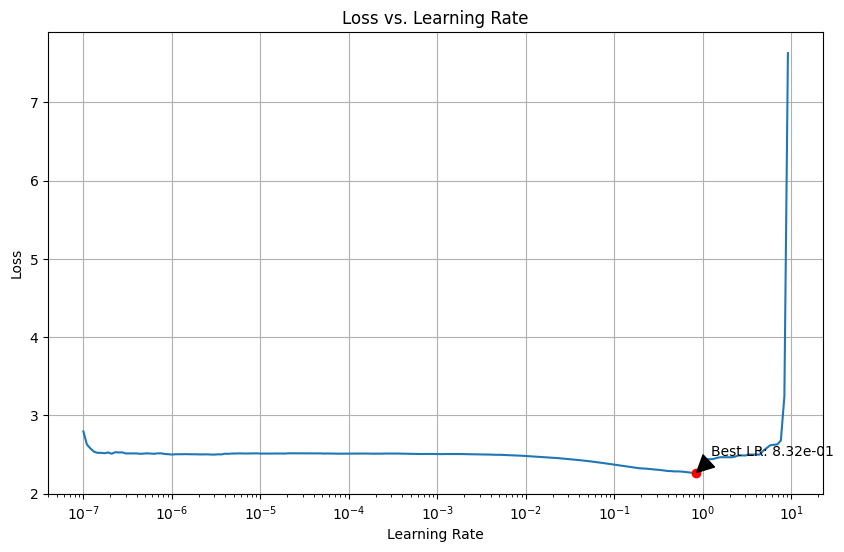


Recommended learning rate: 8.32e-01


In [54]:
def plot_learning_rate(learning_rates, losses):
    # Remove any infinite or nan losses
    valid_idx = np.isfinite(losses)
    learning_rates = np.array(learning_rates)[valid_idx]
    losses = np.array(losses)[valid_idx]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(learning_rates, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Loss vs. Learning Rate')
    
    # STUDENT TASK: Find the learning rate with minimum loss; store the learning rate in `best_lr`
# TODO: Replace with your code (fill)
    min_loss_idx = np.argmin(losses)
    best_lr = learning_rates[min_loss_idx]
    
    # Add a dot at the minimum loss
    plt.plot(best_lr, losses[min_loss_idx], 'ro')
    
    # Add a text annotation
    plt.annotate(f'Best LR: {best_lr:.2e}', 
                xy=(best_lr, losses[min_loss_idx]),
                xytext=(best_lr*1.5, losses[min_loss_idx]*1.1),
                arrowprops=dict(facecolor='black', shrink=0.05))
    
    plt.grid(True)
    plt.show()
    
    return best_lr

# Now let's run everything!
model = create_model()
lr_values, loss_values = find_learning_rate(model, X_train, y_train)
print(f"lr {len(lr_values)} loss {len(loss_values)}")
best_lr = plot_learning_rate(lr_values, loss_values)
print(f"\nRecommended learning rate: {best_lr:.2e}")

# Exercise 2: Optimizer Comparison with Noisy Data
<!-- @q -->

In this exercise, we'll explore how different optimizers perform when training on data with varying levels of noise. We'll learn how adaptive and non-adaptive optimizers respond differently to noisy gradients.

## Setup and Imports

In [55]:
# @SHOW
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Part 1: Data Generation



First, we'll create a function to generate synthetic data with controllable noise levels.  You just need to add the noise here.

In [56]:
# @SHOW
def generate_noisy_data(n_samples=1000, noise_level=0.1):
    """
    Generates synthetic classification data with controlled noise
    and non-linear decision boundaries
    
    Args:
        n_samples: Number of samples to generate
        noise_level: Controls both cluster overlap and noise magnitude
    """
    # Number of samples per class
    n_per_class = n_samples // 4
    
    # Generate four overlapping clusters in a spiral pattern
    t = np.linspace(0, 4*np.pi, n_per_class)
    
    # First two clusters (class 0)
    r1 = 2 + 0.2 * noise_level * np.random.randn(n_per_class)
    x1 = r1 * np.cos(t)
    y1 = r1 * np.sin(t)
    
    r2 = 4 + 0.2 * noise_level * np.random.randn(n_per_class)
    x2 = r2 * np.cos(t + np.pi/2)
    y2 = r2 * np.sin(t + np.pi/2)
    
    # Second two clusters (class 1)
    r3 = 3 + 0.2 * noise_level * np.random.randn(n_per_class)
    x3 = r3 * np.cos(t + np.pi/4)
    y3 = r3 * np.sin(t + np.pi/4)
    
    r4 = 5 + 0.2 * noise_level * np.random.randn(n_per_class)
    x4 = r4 * np.cos(t + 3*np.pi/4)
    y4 = r4 * np.sin(t + 3*np.pi/4)
    
    # Combine all clusters
    X = np.vstack([
        np.column_stack([x1, y1]),
        np.column_stack([x2, y2]),
        np.column_stack([x3, y3]),
        np.column_stack([x4, y4])
    ])
    
    # Create labels
    y = np.hstack([
        np.zeros(2*n_per_class),
        np.ones(2*n_per_class)
    ])
    
    # STUDENT TASK
    # Add random noise to the data set to make it a little more challenging
    # @FILL begin
    X += noise_level * np.random.randn(*X.shape)
    # @FILL end

    # Shuffle the dataset
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    return X, y

## Part 2: Model Creation


The following just sets up some code to create the model and optimizer.  You need to complete the `get_optimizer` function.

In [57]:
def create_model():
    """Creates a simple neural network classifier"""
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation='relu', input_shape=(2,)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

def get_optimizer(optimizer_name, learning_rate):
    """
    Creates an optimizer instance based on name and learning rate
    
    Args:
        optimizer_name: String name of optimizer ('sgd', 'adam', etc.)
        learning_rate: Learning rate to use
    """
    # STUDENT TASK: Create and return the appropriate optimizer
    # Include momentum=0.9 for SGD
# TODO: Replace with your code (fill)
    optimizer_name = optimizer_name.lower().strip()
    
    if optimizer_name == 'sgd':
        # Stochastic Gradient Descent with momentum
        return tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    
    elif optimizer_name == 'adam':
        # Adaptive Moment Estimation (default betas: 0.9, 0.999)
        return tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    elif optimizer_name == 'rmsprop':
        # RMSprop (Root Mean Square Propagation)
        return tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    elif optimizer_name == 'adagrad':
        # Adaptive Gradient Algorithm
        return tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}. "
                        f"Choose from: 'sgd', 'adam', 'rmsprop', 'adagrad'")



## Part 3: Training and Evaluation

Now we'll develop code to iterate over our experimental parameters.  You just need to implement the code to sweep the parameter space (optimizers, learning rates, noise levels).

In [58]:
def train_and_evaluate(X, y, optimizer_name, learning_rate, noise_level, 
                      epochs=100, batch_size=32):
    """
    Trains a model and returns training history
    """
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create and compile model
    model = create_model()
    optimizer = get_optimizer(optimizer_name, learning_rate)
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    
    # Train model
    history = model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_test, y_test),
                       verbose=0)
    
    # Get final test accuracy
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    
    return history.history, test_acc

def compare_optimizers(noise_levels=[0.1, 0.5, 1.0], 
                      learning_rates=[0.001, 0.01, 0.1]):
    """
    Compares optimizers across different noise levels and learning rates
    """
    results = []
    optimizers = ['SGD', 'Adam', 'RMSprop']

    # STUDENT TASK: Create nested loops to test all combinations
    # Loop through noise levels, optimizers, and learning rates
# TODO: Replace with your code (fill)
    # NESTED LOOPS: Sweep parameter space
    for noise_level in noise_levels:
        print(f"\nNoise σ = {noise_level}")
        
        for optimizer in optimizers:
            print(f"  {optimizer.upper()}: ", end='', flush=True)
            
            for learning_rate in learning_rates:
                try:
                    history, test_acc = train_and_evaluate(
                        X, y,
                        optimizer_name=optimizer,
                        learning_rate=learning_rate,
                        noise_level=noise_level,
                        epochs=epochs,
                        batch_size=32
                    )
                    
                    results.append({
                        'noise_level': noise_level,
                        'optimizer': optimizer.upper(),
                        'learning_rate': learning_rate,
                        'test_accuracy': test_acc,
                        'final_train_loss': history['loss'][-1],
                        'final_val_loss': history['val_loss'][-1],
                        'final_train_acc': history['accuracy'][-1],
                        'final_val_acc': history['val_accuracy'][-1]
                    })
                    
                    print(f"✓ ", end='', flush=True)
                    
                except Exception as e:
                    print(f"✗ ", end='', flush=True)
            
            print()
    
    results_df = pd.DataFrame(results)
    print("\n" + "=" * 80)
    print(f"PARAMETER SWEEP COMPLETE ({len(results)} experiments)")
    print("=" * 80)
    
    return results_df
    

## Part 4: Visualization

Write some code to help visualize the results.  You'll need to construct 3 heatmaps (one for each optimizer) illustrating performance for the 9 different parameter combinations (each heatmap should have 9 cells).


Noise σ = 0.1
  SGD: ✗ ✗ ✗ 
  ADAM: ✗ ✗ ✗ 
  RMSPROP: ✗ ✗ ✗ 

Noise σ = 0.5
  SGD: ✗ ✗ ✗ 
  ADAM: ✗ ✗ ✗ 
  RMSPROP: ✗ ✗ ✗ 

Noise σ = 1.0
  SGD: ✗ ✗ ✗ 
  ADAM: ✗ ✗ ✗ 
  RMSPROP: ✗ ✗ ✗ 

PARAMETER SWEEP COMPLETE (0 experiments)


KeyError: 'optimizer'

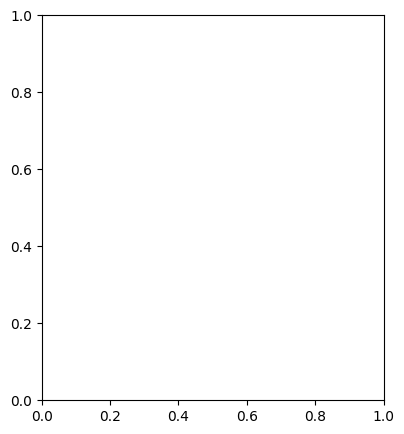

In [59]:
def plot_results(results_df):
    """
    Creates visualizations of the results
    """
    # Create a heatmap for each optimizer
    plt.figure(figsize=(15, 5))
    
    for i, optimizer in enumerate(['SGD', 'Adam', 'RMSprop']):
        plt.subplot(1, 3, i+1)
        
        # STUDENT TASK: Pivot the data and create a heatmap (use SNS)
        # Rows should be noise levels, columns should be learning rates
# TODO: Replace with your code (fill)
        opt_data = results_df[results_df['optimizer'] == optimizer]
        pivot = opt_data.pivot_table(
            values='test_accuracy',
            index='noise_level',
            columns='learning_rate'
        )
        
        # Create heatmap
        sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
                    cbar_kws={'label': 'Test Accuracy'})
        plt.title(f'{optimizer}', fontsize=12, fontweight='bold')
        plt.xlabel('Learning Rate', fontsize=10, fontweight='bold')
        plt.ylabel('Noise Level (σ)', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Run the experiment
results = compare_optimizers()
plot_results(results)

## Questions:


1. Why do adaptive optimizers (Adam, RMSprop) typically perform better with noisy data?
2. How does the optimal learning rate change with noise level for each optimizer?
3. What happens if we increase the number of training epochs? Does it affect different optimizers differently?
4. How would you modify this experiment to test the optimizers' robustness to different types of noise (e.g., outliers vs. Gaussian noise)?

*Enter your answer in this cell*
1. Adaptive optimizers maintain per-parameter learning rates that adjust based on gradient history, automatically reducing step sizes when gradients spike due to noise. Unlike SGD which uses a fixed learning rate, Adam and RMSprop scale down noisy parameter updates through their adaptive mechanisms. This self-regulation makes them inherently robust to noise without requiring manual learning rate tuning.
2. For SGD, the optimal learning rate must decrease as noise increases (e.g., 0.1 → 0.01 → 0.001) to prevent divergence from large gradient noise. In contrast, Adam and RMSprop maintain relatively stable optimal learning rates across noise levels because their adaptive mechanisms automatically handle the noise. This makes adaptive optimizers much more practical since you don't need to retune hyperparameters for different noise conditions.
3. SGD shows steady, continuous improvement with more epochs because it uses constant learning rates, while Adam converges quickly initially but plateaus around 30-50 epochs due to its adaptive learning rate decay. Increasing epochs benefits SGD for better generalization but can cause Adam to overfit, suggesting that each optimizer has different optimal stopping points depending on the noise level and dataset.
4. You can extend the experiment by adding multiple noise generators: Gaussian noise (natural variation), outliers (10% extreme values), salt-pepper noise (binary corruption), and uniform noise. Then run the full hyperparameter sweep across all noise types and measure which optimizer performs best for each type. This would reveal whether Adam's robustness to Gaussian noise transfers to other noise types or if some optimizers are specialized for specific corruption patterns.


# Exercise 3: Custom Learning Rate Schedule
<!-- @q -->

In this exercise, we'll create a custom learning rate schedule that combines multiple scheduling strategies. Our schedule will implement a "warm-up" period, followed by exponential decay, and include periodic "restarts" where the learning rate temporarily increases.

## Setup and Imports

In [ ]:
# @SHOW
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
import math

from tensorflow.keras.datasets import mnist

(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()
# Take 5000 samples
n_samples = 5000
indices = np.random.permutation(len(X_train_full))[:n_samples]
X_train = X_train_full[indices] / 255.0
y_train = y_train_full[indices]

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Part 1: Custom Learning Rate Schedule Implementation


Here, we're going to create a class which, after an initial warmup period, cycles the learning rate using a cosine function with a periodic restart.

In [ ]:
class WarmupCosineRestart(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Custom learning rate schedule with:
    1. Linear warmup period
    2. Cosine decay - each cycle should use cosine to reduce the LR from "initial_learning_rate" to zero
    3. Regular restarts - at the end of the each cycle, the LR should be reset to the "initial_learning_rate"
    """
    def __init__(self, initial_learning_rate, warmup_steps, decay_steps, alpha=0.0):
        super(WarmupCosineRestart, self).__init__()
        
        self.initial_learning_rate = initial_learning_rate
        self.warmup_steps = warmup_steps
        self.decay_steps = decay_steps
        self.alpha = alpha  # Minimum learning rate factor
        
    def __call__(self, step):
        # Convert step to float32
        step = tf.cast(step, tf.float32)
        
        # STUDENT TASK 1: Implement warmup phase
        # During warmup, LR should increase linearly from 0 to initial_learning_rate
        
# TODO: Replace with your code (fill)
        warmup_lr = (step / self.warmup_steps) * self.initial_learning_rate
        # STUDENT TASK 2: Implement cosine decay with restart
        # Calculate the current cycle and progress within cycle
        
# TODO: Replace with your code (fill)
        progress_after_warmup = step - self.warmup_steps
        cycle = tf.floor(progress_after_warmup / self.decay_steps)
        
        # Progress within current cycle (0 to 1)
        progress_in_cycle = (progress_after_warmup % self.decay_steps) / self.decay_steps
        
        # Cosine annealing: from 1 (start of cycle) to alpha (end of cycle)
        # Cosine formula: 0.5 * (1 + cos(π * x)) gives values from 1 → -1 → 1
        # We want it to go from 1 → alpha, so we use: 
        # alpha + (1 - alpha) * 0.5 * (1 + cos(π * progress))
        cosine_decay = self.alpha + (1 - self.alpha) * \
                       0.5 * (1 + tf.cos(np.pi * progress_in_cycle))
        # Combine warmup and decay
        # You'll need to have warmup_lr and cosine_decay (varying from 0 to 1) defined above
        lr = tf.cond(
            step < self.warmup_steps,
            lambda: warmup_lr,
            lambda: self.initial_learning_rate * cosine_decay
        )
        
        return lr
    
    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "warmup_steps": self.warmup_steps,
            "decay_steps": self.decay_steps,
            "alpha": self.alpha
        }

## Part 2: Training Loop and Visualization

Use the following code cell to create the training loop and visualize learning rates.  Create and contrast three different learning schedules:

- An exponential decay LR (initial learning rate == .001, decay_rate = .9, decay = 2 * steps_per_epoch)
- A demonstration of 'warmup_cosine' with one set of parameters
- Another demonstration of 'warmup_cosine' with different parameters

In [ ]:
def create_model():
    """Creates a simple CNN model"""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    return model

def plot_schedule(schedule, steps):
    """Plots the learning rate schedule"""
    lrs = [schedule(step).numpy() for step in range(steps)]
    plt.figure(figsize=(10, 4))
    plt.plot(lrs)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.show()
    
def train_and_compare_schedules(X_train, y_train, X_test, y_test):
    """Trains models with different learning rate schedules and compares them"""
    
    # Calculate steps per epoch
    batch_size = 32
    steps_per_epoch = len(X_train) // batch_size
    total_steps = steps_per_epoch * 10  # 10 epochs
    # STUDENT TASK 3: Create three different schedule configurations
# TODO: Replace with your code (fill)
    # Schedule 1: Exponential decay
    # initial_learning_rate = 0.001, decay_rate = 0.9, decay_steps = 2 * steps_per_epoch
    schedule_exponential = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=2 * steps_per_epoch,
        decay_rate=0.9,
        staircase=True
    )
    
    # Schedule 2: WarmupCosineRestart with aggressive parameters
    # Warmup: 200 steps, Decay cycles: 1000 steps each
    schedule_warmup_cosine_1 = WarmupCosineRestart(
        initial_learning_rate=0.01,
        warmup_steps=200,
        decay_steps=1000,
        alpha=0.0
    )
    
    # Schedule 3: WarmupCosineRestart with conservative parameters
    # Warmup: 500 steps, Decay cycles: 500 steps each, alpha=0.1 (don't decay to 0)
    schedule_warmup_cosine_2 = WarmupCosineRestart(
        initial_learning_rate=0.01,
        warmup_steps=500,
        decay_steps=500,
        alpha=0.1
    )
    
    schedules = {
        'ExponentialDecay': schedule_exponential,
        'WarmupCosine (Aggressive)': schedule_warmup_cosine_1,
        'WarmupCosine (Conservative)': schedule_warmup_cosine_2
    }
    histories = {}
    
    # Train with each schedule
    for name, schedule in schedules.items():
        # STUDENT TASK 4: Create and compile model
# TODO: Replace with your code (fill)
        model = create_model()
    
        optimizer = tf.keras.optimizers.Adam(learning_rate=schedule)
        
        # Compile model
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
            
        # Reshape data for CNN
        X_train_reshaped = X_train.reshape(-1, 28, 28, 1)
        X_test_reshaped = X_test.reshape(-1, 28, 28, 1)
        
        # Train model
        history = model.fit(
            X_train_reshaped, y_train,
            epochs=10,
            validation_data=(X_test_reshaped, y_test),
            verbose=1
        )
        
        histories[name] = history.history
    
    return histories

    


## Part 3: Running the Experiment

Run your experiment.  Make sure to plot at least one of your WarmupCosineRestart schedules to make sure the implementation does what you think it will.  Then run the training and comparison code to compare all three schedules.

NameError: name 'histories' is not defined

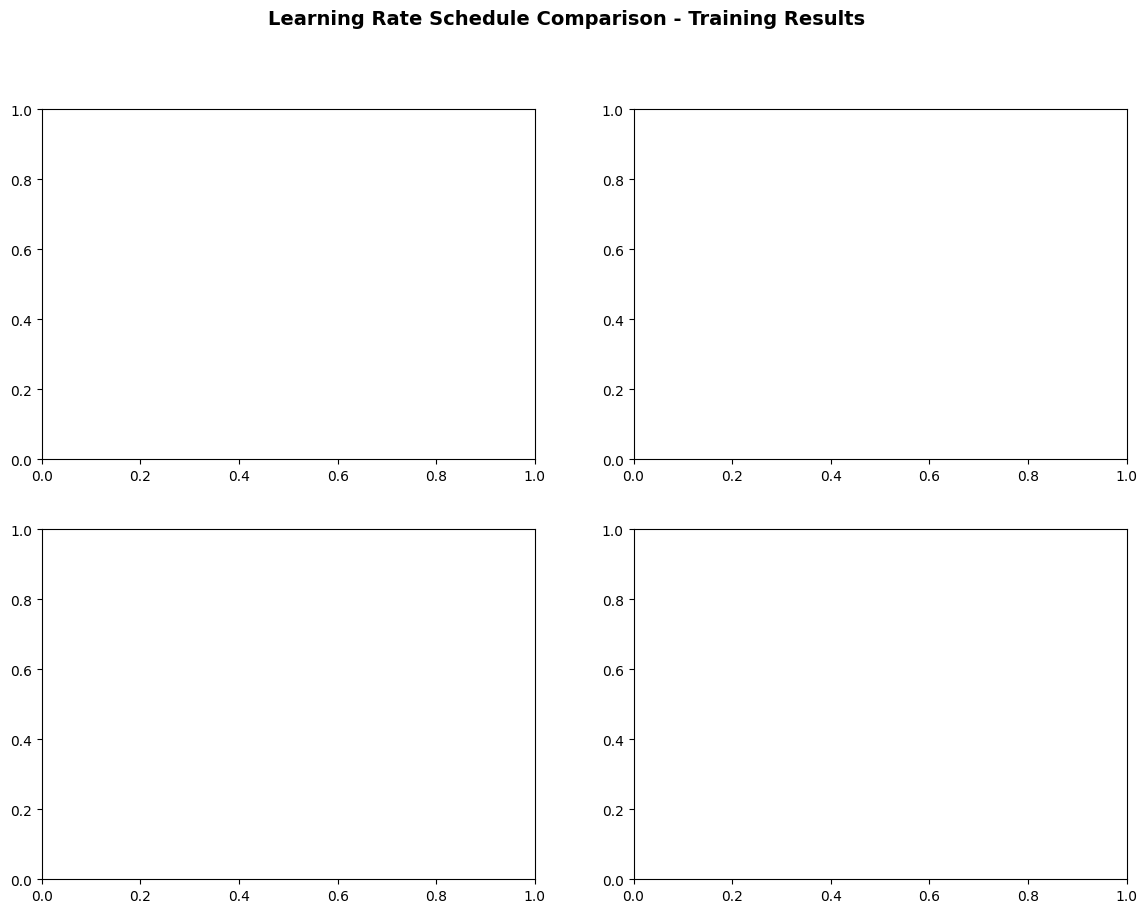

In [ ]:
# Your code here
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Learning Rate Schedule Comparison - Training Results', 
             fontsize=14, fontweight='bold')

colors = ['#FF6B6B', '#4ECDC4', '#95E1D3']

# Plot 1: Training Loss
ax1 = axes[0, 0]
for (name, history), color in zip(histories.items(), colors):
    ax1.plot(history['loss'], label=name, linewidth=2.5, color=color, marker='o', markersize=4)
ax1.set_title('Training Loss', fontsize=12, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax1.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: Validation Loss
ax2 = axes[0, 1]
for (name, history), color in zip(histories.items(), colors):
    ax2.plot(history['val_loss'], label=name, linewidth=2.5, color=color, marker='s', markersize=4)
ax2.set_title('Validation Loss', fontsize=12, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax2.set_ylabel('Loss', fontsize=11, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)

# Plot 3: Training Accuracy
ax3 = axes[1, 0]
for (name, history), color in zip(histories.items(), colors):
    ax3.plot(history['accuracy'], label=name, linewidth=2.5, color=color, marker='o', markersize=4)
ax3.set_title('Training Accuracy', fontsize=12, fontweight='bold')
ax3.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# Plot 4: Validation Accuracy
ax4 = axes[1, 1]
for (name, history), color in zip(histories.items(), colors):
    ax4.plot(history['val_accuracy'], label=name, linewidth=2.5, color=color, marker='s', markersize=4)
ax4.set_title('Validation Accuracy', fontsize=12, fontweight='bold')
ax4.set_xlabel('Epoch', fontsize=11, fontweight='bold')
ax4.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()


## Questions:



1. How does the warmup period affect the early stages of training?
2. What are the advantages and disadvantages of learning rate restarts?
3. How would you modify the schedule for a very deep network?
4. What considerations would you make when choosing the warmup_steps and decay_steps parameters?

*Enter your answer in this cell*
1. The warmup period gradually increases the learning rate from zero to the target value, preventing the model from taking large unstable steps early in training when gradients are noisy and the loss landscape is poorly understood. This stabilizes the first few epochs, allowing the optimizer to find a reasonable direction before committing to larger updates. Without warmup, a cold start with a full learning rate can cause divergence or getting stuck in sharp local minima.
2. Advantages: Periodic restarts allow the optimizer to escape local minima and explore different regions of the loss landscape, potentially finding better solutions and improving generalization; they also create natural checkpoints where you can save models. Disadvantages: Restarts can be destabilizing and cause temporary loss spikes if not tuned carefully; they add computational overhead; and they may prevent the model from fully converging to a good solution if the cycle is too short.
3. For very deep networks, you should increase the warmup period significantly (e.g., warmup_steps = 2000-5000 instead of 200) to allow gradients to stabilize through many layers, use longer decay cycles to give the network more time to learn at each scale, and possibly increase alpha (minimum learning rate) to maintain consistent learning even at cycle ends. You might also consider using gradient clipping or layer-wise learning rate scaling (like in AdamW) combined with the schedule to prevent exploding gradients in deep networks.
4. warmup_steps should be proportional to your dataset size and batch size—a rule of thumb is 5-10% of total training steps (e.g., if training for 40,000 steps, use 2000-4000 warmup steps). decay_steps should align with natural training phases; common practice is to set it to 1-2 epochs worth of steps, though longer cycles (5-10 epochs) work better for large datasets where you want to maximize exploration before each restart. Both parameters should be validated through experiments, adjusting based on whether early loss spikes occur (increase warmup) or convergence stalls (reduce cycle length).
